In [667]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from mpl_toolkits.mplot3d import Axes3D


In [668]:
data = pd.read_csv("Datasets/cybersecurity_intrusion_data.csv")
data

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0
...,...,...,...,...,...,...,...,...,...,...,...
9532,SID_09533,194,ICMP,3,226.049889,AES,0.517737,3,Chrome,0,1
9533,SID_09534,380,TCP,3,182.848475,NaN,0.408485,0,Chrome,0,0
9534,SID_09535,664,TCP,5,35.170248,AES,0.359200,1,Firefox,0,0
9535,SID_09536,406,TCP,4,86.664703,AES,0.537417,1,Chrome,1,0


# Descriptive analysis of your data

### Analysis of numerical values

In [671]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   session_id           9537 non-null   object 
 1   network_packet_size  9537 non-null   int64  
 2   protocol_type        9537 non-null   object 
 3   login_attempts       9537 non-null   int64  
 4   session_duration     9537 non-null   float64
 5   encryption_used      7571 non-null   object 
 6   ip_reputation_score  9537 non-null   float64
 7   failed_logins        9537 non-null   int64  
 8   browser_type         9537 non-null   object 
 9   unusual_time_access  9537 non-null   int64  
 10  attack_detected      9537 non-null   int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 819.7+ KB


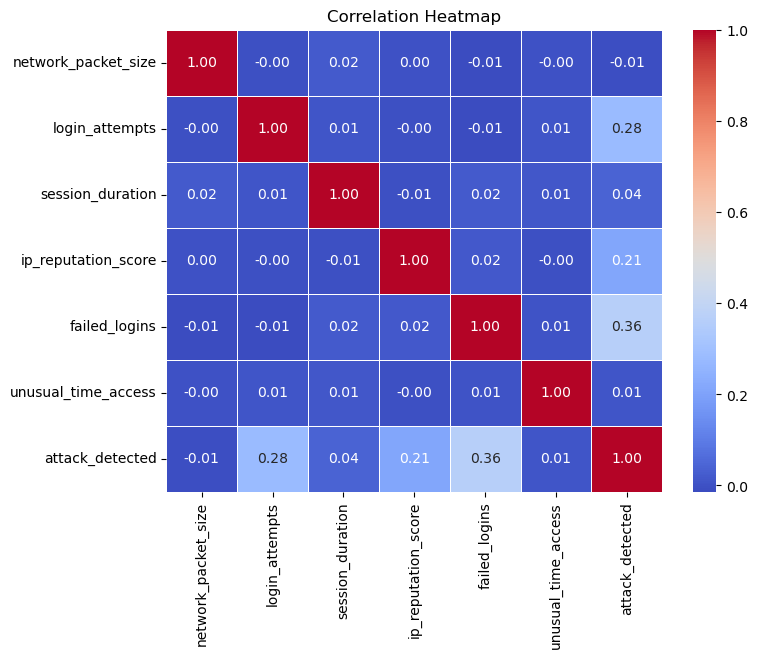

In [672]:
# Correlation matrix
num_values = ["network_packet_size", "login_attempts", "session_duration","ip_reputation_score","failed_logins","unusual_time_access","attack_detected"]
matrix = data[num_values].corr()
plt.figure(figsize=(8,6))
sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

We can observe that login_attempts, ip_reputation_score, failed_login are the most correlated features to attack_detected

In [674]:
### Distribution graphs
relevant_columns = [col for col in data.columns if col not in ['attack_detected', 'session_id']]

print("\nRelevant Columns :")
print(relevant_columns)

numerical_columns = []
categorical_columns = []

for col in relevant_columns:
    if data[col].dtype in ['int64', 'float64']:
        numerical_columns.append(col)
    elif data[col].dtype == 'object':
        if data[col].apply(lambda x: isinstance(x, str)).any():
            categorical_columns.append(col)
        else:
            numerical_columns.append(col)
    elif data[col].dtype == 'category':
        categorical_columns.append(col)


print("\nnumerical columns :")
print(numerical_columns)
print("\nCategorical columns :")
print(categorical_columns)


Relevant Columns :
['network_packet_size', 'protocol_type', 'login_attempts', 'session_duration', 'encryption_used', 'ip_reputation_score', 'failed_logins', 'browser_type', 'unusual_time_access']

numerical columns :
['network_packet_size', 'login_attempts', 'session_duration', 'ip_reputation_score', 'failed_logins', 'unusual_time_access']

Categorical columns :
['protocol_type', 'encryption_used', 'browser_type']


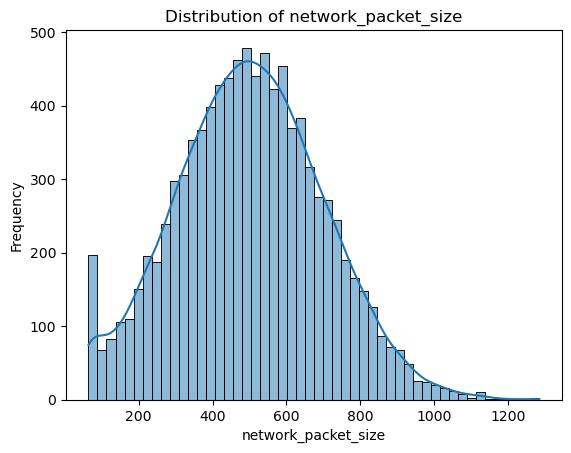

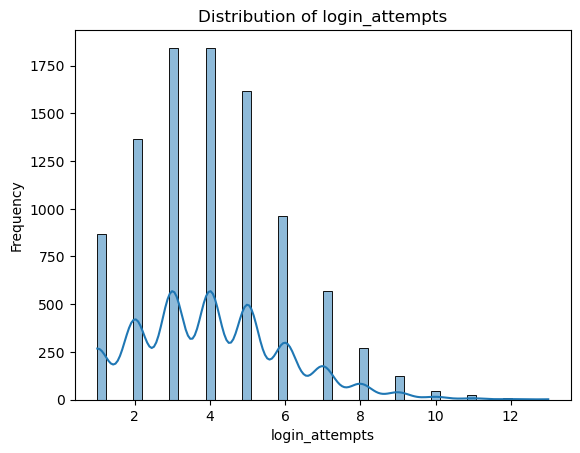

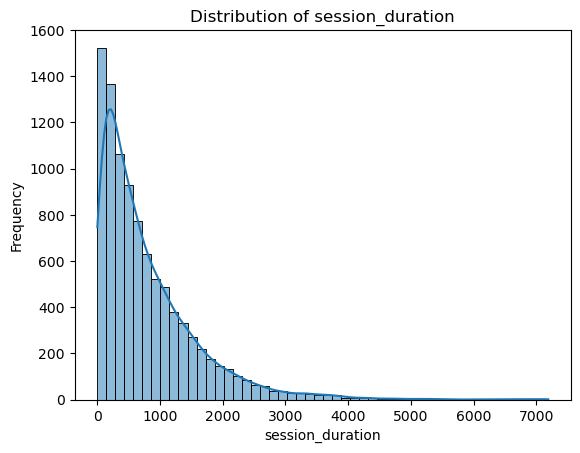

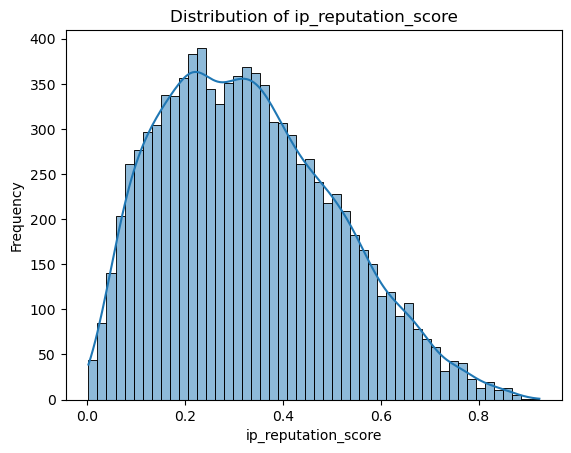

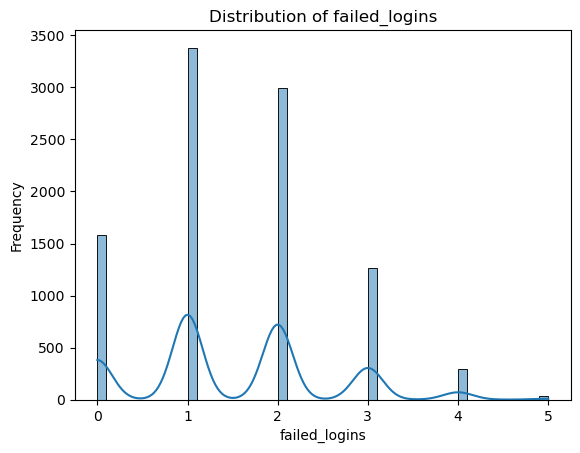

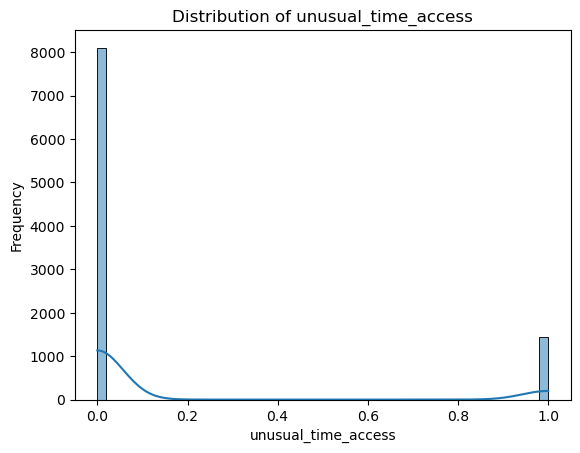

In [675]:

for col in numerical_columns:
    sns.histplot(data=data, x=col, bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

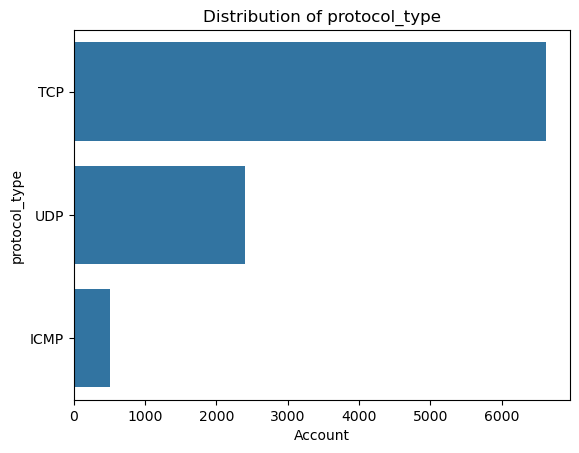

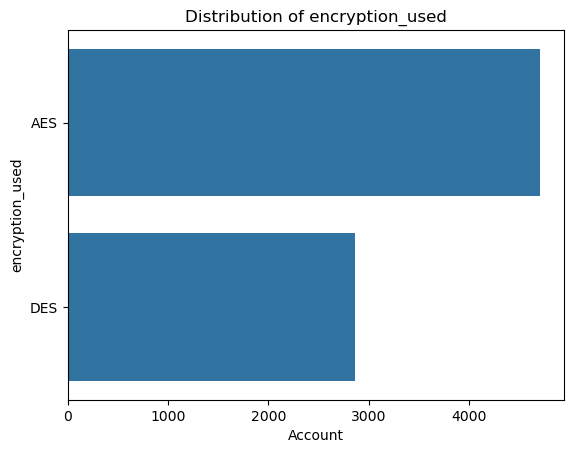

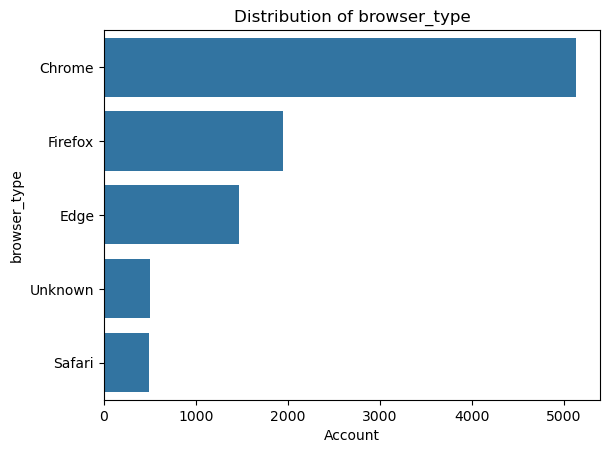

In [676]:

for col in categorical_columns:

    sns.countplot(data=data, y=col, order=data[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xlabel('Account')
    plt.ylabel(col)
    plt.show()

In [677]:
df = pd.DataFrame(data=data.values, columns=data.columns)

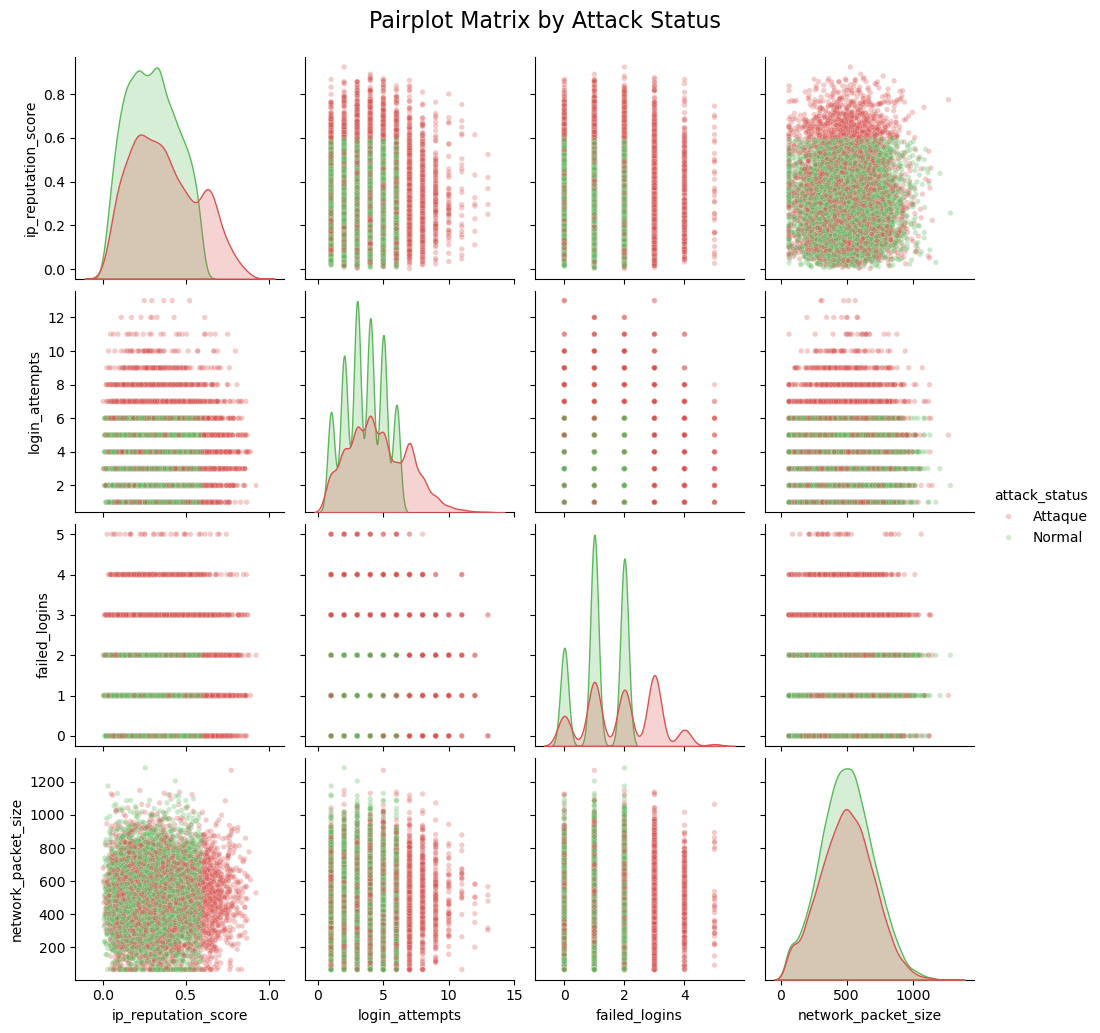

In [678]:
# Convert the numerical 'attack_detected' column (0 or 1)
# into a categorical string ('Attack' or 'Normal') for the legend.
df['attack_status'] = df['attack_detected'].apply(lambda x: 'Attaque' if x == 1 else 'Normal')

#Data Preparation
# Select a subset of columns to plot.
# A full pairplot with all columns would be too large and unreadable.
columns_to_plot = [
    'ip_reputation_score',
    'login_attempts',
    'failed_logins',
    'network_packet_size',
    'attack_status' # This column will be used for coloring ('hue')
]

# Create a new DataFrame from the selected columns.
# .copy() is used to avoid a 'SettingWithCopyWarning' from pandas.
df_subset = df[columns_to_plot].copy()

# Create and Display the Plot
# 'sns.pairplot' creates a grid of scatterplots for every pair of columns.
# The diagonal plots are histograms (or density plots) for each variable.
g = sns.pairplot(
    df_subset, 
    hue='attack_status', # Color the points based on the 'attack_status' column
    palette={'Normal': '#5CB85C', 'Attaque': '#D9534F'}, # Assign custom colors (Green/Red)
    plot_kws={'alpha': 0.3, 's': 15} # 'plot_kws' arguments:
                                     # 'alpha=0.3' makes points 30% transparent to see overlaps
                                     # 's=15' sets the size of the points
)


g.fig.suptitle("Pairplot Matrix by Attack Status", y=1.03, fontsize=16)
plt.show()

The pairplot analysis highlights clear differences between normal and attack instances. 
Features such as ip_reputation_score, login_attempts, and failed_logins show strong discriminative power: attack samples tend to have lower IP reputation scores 
and higher login attempts and failures. 
In contrast, network_packet_size shows little distinction between the two classes. 
The observed correlation between login_attempts and failed_logins is coherent. 
Overall, these insights indicate that the dataset is well-suited for binary supervised learning

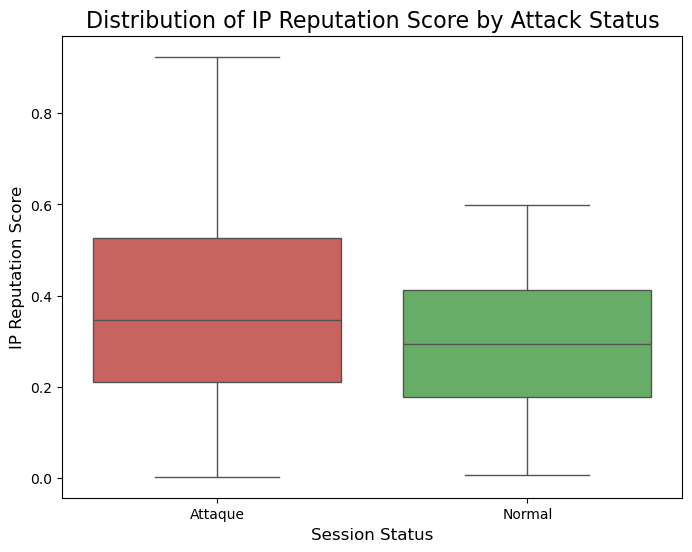

In [680]:
# Convert the 'attack_detected' column (0 or 1) into a string
# This makes the plot labels ('Attack' / 'Normal') more readable
df['attack_status'] = df['attack_detected'].apply(lambda x: 'Attaque' if x == 1 else 'Normal')

plt.figure(figsize=(8, 6))

sns.boxplot(
    data=df,                      
    x='attack_status',           
    y='ip_reputation_score',    
    
    # 1. Assign the x-variable ('attack_status') to 'hue'
    hue='attack_status',
    palette={'Normal': '#5CB85C', 'Attaque': '#D9534F'},              

)

plt.title('Distribution of IP Reputation Score by Attack Status', fontsize=16)
plt.xlabel('Session Status', fontsize=12)
plt.ylabel('IP Reputation Score', fontsize=12)
plt.show()

This box plot compares the IP Reputation Score for "Normal" (green) and "Attaque" (red) sessions, revealing that attacks are strongly correlated with higher reputation scores. We can clearly see the red box (Attaque) is positioned significantly higher on the graph, with a median score around 0.38, compared to the green box (Normal) which has a lower median of approximately 0.25. This difference demonstrates that ip_reputation_score is a valuable indicator for identifying malicious activity, as a high score is a major red flag, even though outliers show some attacks can still come from low-reputation IPs.

### Analysis of the categorial values

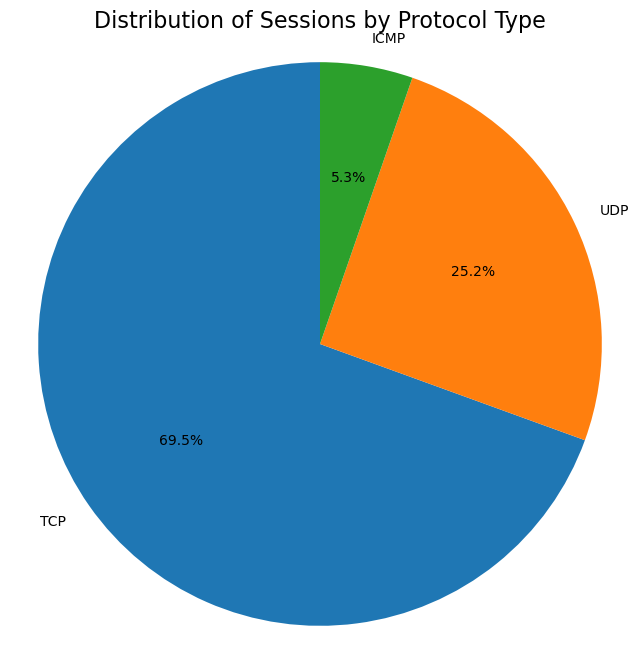

In [683]:
# --- Pie Chart 1: Protocol Type ---

# 1. Get the data for the pie chart
# .value_counts() calculates the size of each slice
protocol_counts = df['protocol_type'].value_counts()

# 2. Get the labels (e.g., 'TCP', 'UDP', 'ICMP')
protocol_labels = protocol_counts.index

# 3. Get the numerical values (the counts for each slice)
protocol_sizes = protocol_counts.values

plt.figure(figsize=(8, 8)) # Set the figure size to be a square
plt.pie(
    protocol_sizes,      # The numerical values for each slice
    labels=protocol_labels, # The text labels for each slice
    autopct='%1.1f%%',   # Format to show percentages (e.g., '10.1%')
    startangle=90        # Start the first slice at the 90-degree (top) position
)

plt.title('Distribution of Sessions by Protocol Type', fontsize=16)
plt.axis('equal') 
plt.show()

Here we see that TCP is the dominant protocol type in the dataset, accounting for the majority of sessions. However, there is also a significant portion of UDP and a smaller fraction of ICMP traffic.
From this point, we might consider analyzing how attack patterns differ across these protocol types in future analyses.

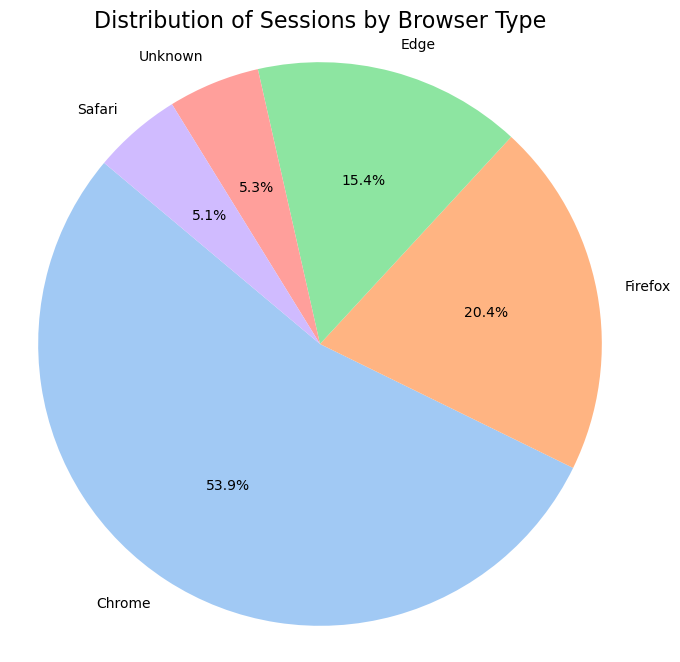

In [685]:
# --- Pie Chart 2: Browser Type (with explode) ---

# 1. Get the data
browser_counts = df['browser_type'].value_counts()
browser_labels = browser_counts.index
browser_sizes = browser_counts.values


colors = sns.color_palette('pastel')[0:5]

plt.figure(figsize=(8, 8))
plt.pie(
    browser_sizes,
    labels=browser_labels,
    autopct='%1.1f%%',
    startangle=140,       # Start at a different angle
    colors=colors         # Apply the custom color palette
)


plt.title('Distribution of Sessions by Browser Type', fontsize=16)
plt.axis('equal')
plt.show()

Here we observe that Chrome is the most commonly used browser in the dataset, followed by Firefox and Safari. Edge and Opera have smaller shares. 
This distribution may reflect general user preferences or specific targeting by attackers. Nothing can be concluded yet without further analysis.

# Preprocessing

### Cleaning data

In [689]:
# Checking for null values or NaN
print("Number of Null :\n",data.isnull().sum())

# Dropping the null values
data_cleaned = data.dropna(axis=0)
print("\nNumber of Null :\n",data_cleaned.isnull().sum())

# session_id here is not relevant
data_cleaned = data_cleaned.drop("session_id", axis=1)

Number of Null :
 session_id                0
network_packet_size       0
protocol_type             0
login_attempts            0
session_duration          0
encryption_used        1966
ip_reputation_score       0
failed_logins             0
browser_type              0
unusual_time_access       0
attack_detected           0
dtype: int64

Number of Null :
 session_id             0
network_packet_size    0
protocol_type          0
login_attempts         0
session_duration       0
encryption_used        0
ip_reputation_score    0
failed_logins          0
browser_type           0
unusual_time_access    0
attack_detected        0
dtype: int64


In [690]:
X, y = data_cleaned.drop("attack_detected", axis=1), data_cleaned["attack_detected"]

### Checking class distribution

Class distribution:
 attack_detected
0    5273
1    4264
Name: count, dtype: int64
Imbalance ratio ≈ 1:1.24


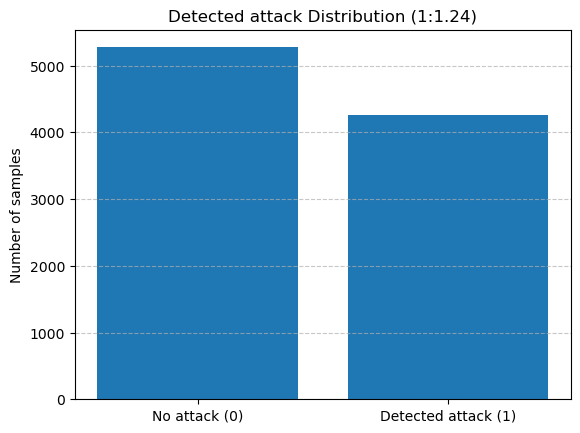

In [692]:
class_counts = data['attack_detected'].value_counts()
print("Class distribution:\n", class_counts)
minority = class_counts.min()
majority = class_counts.max()
ratio = majority/minority
print(f"Imbalance ratio ≈ 1:{ratio:.2f}")

plt.bar(['No attack (0)', 'Detected attack (1)'], class_counts)
plt.title(f"Detected attack Distribution (1:{ratio:.2f})")
plt.ylabel("Number of samples")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

We have a slight imbalance (the ratio is 1.24, close to 1) that we can correct by either undersampling the minority class 0 or oversampling the majority class 1, with random under/oversampling or SMOTE
Undersampling could make us to lose some valuables informations while the oversampling could create points and overfitting if a class gap between is too big.
Since we only have about 1000 points of difference, we will use oversampling on the training set. We don't have that much points to begin with so removing some could lead to loss of information.

### Transforming categorial data into numerical data
We need to transform ['protocol_type', 'encryption_used', 'browser_type'] into numeric data.
As these categories has at most five categories, we can use the one-hot encoding (which consists of having two binary columns describing it's category 1 and if it's category 2 (and more).
We could introduce labels meaning we would associate number to each category of a feature. Although, it could introduce ordinal features in the said feature which means there would be an order of importance in the features when there isn't in reality (Chrome, Edge or other browser aren't more important than the others for example) and influence the predicition.

In [695]:
X, y = data_cleaned.drop("attack_detected", axis=1), data_cleaned["attack_detected"]

# encryption_used
dummies = pd.get_dummies(X['encryption_used'])
X = pd.concat([X, dummies], axis=1)
X.drop("encryption_used", axis=1, inplace=True)

# browser_type
dummies = pd.get_dummies(X['browser_type'])
X = pd.concat([X, dummies], axis=1)
X.drop("browser_type", axis=1, inplace=True)

# protocol_type
dummies = pd.get_dummies(X['protocol_type'])
X = pd.concat([X, dummies], axis=1)
X.drop("protocol_type", axis=1, inplace=True)

In [696]:
X

,network_packet_size,login_attempts,session_duration,ip_reputation_score,failed_logins,unusual_time_access,AES,DES,Chrome,Edge,Firefox,Safari,Unknown,ICMP,TCP,UDP
0,599,4,492.983263,0.606818,1,0,False,True,False,True,False,False,False,False,True,False
1,472,3,1557.996461,0.301569,0,0,False,True,False,False,True,False,False,False,True,False
2,629,3,75.044262,0.739164,2,0,False,True,True,False,False,False,False,False,True,False
3,804,4,601.248835,0.123267,0,0,False,True,False,False,False,False,True,False,False,True
4,453,5,532.540888,0.054874,1,0,True,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9528,535,7,50.518476,0.767659,1,1,False,True,False,True,False,False,False,False,True,False
9531,746,7,315.151758,0.190059,3,0,False,True,True,False,False,False,False,False,True,False
9532,194,3,226.049889,0.517737,3,0,True,False,True,False,False,False,False,True,False,False
9534,664,5,35.170248,0.359200,1,0,True,False,False,False,True,False,False,False,True,False


### PCA

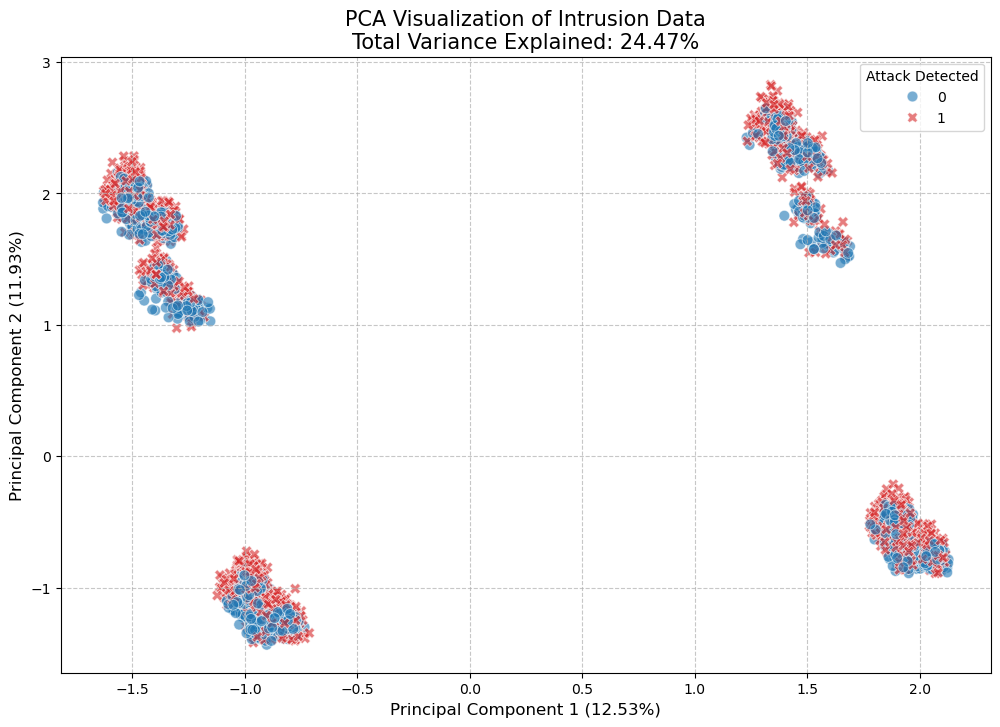

In [698]:
# 1. Standardize the Data

scaler_pca = StandardScaler()
X_scaled_for_pca = scaler_pca.fit_transform(X)

# 2. Apply PCA (Reduce to 2 dimensions)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled_for_pca)

# 3. Create a DataFrame specifically for plotting
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Target'] = y.values  # We use y.values to ensure alignment

# 4. Calculate how much information (variance) we kept
var_explained = pca.explained_variance_ratio_.sum() * 100
pc1_var = pca.explained_variance_ratio_[0] * 100
pc2_var = pca.explained_variance_ratio_[1] * 100

# 5. Plot the 2D Visualization
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PC1', 
    y='PC2',
    hue='Target', 
    data=pca_df,
    palette={0: 'tab:blue', 1: 'tab:red'}, # Blue for Normal, Red for Attack
    style='Target',    # Different shapes for different classes
    alpha=0.6,         # Transparency to see overlapping points
    s=60               # Dot size
)

plt.title(f'PCA Visualization of Intrusion Data\nTotal Variance Explained: {var_explained:.2f}%', fontsize=15)
plt.xlabel(f'Principal Component 1 ({pc1_var:.2f}%)', fontsize=12)
plt.ylabel(f'Principal Component 2 ({pc2_var:.2f}%)', fontsize=12)
plt.legend(title='Attack Detected', loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

Total Variance Explained in 3D: 34.75%


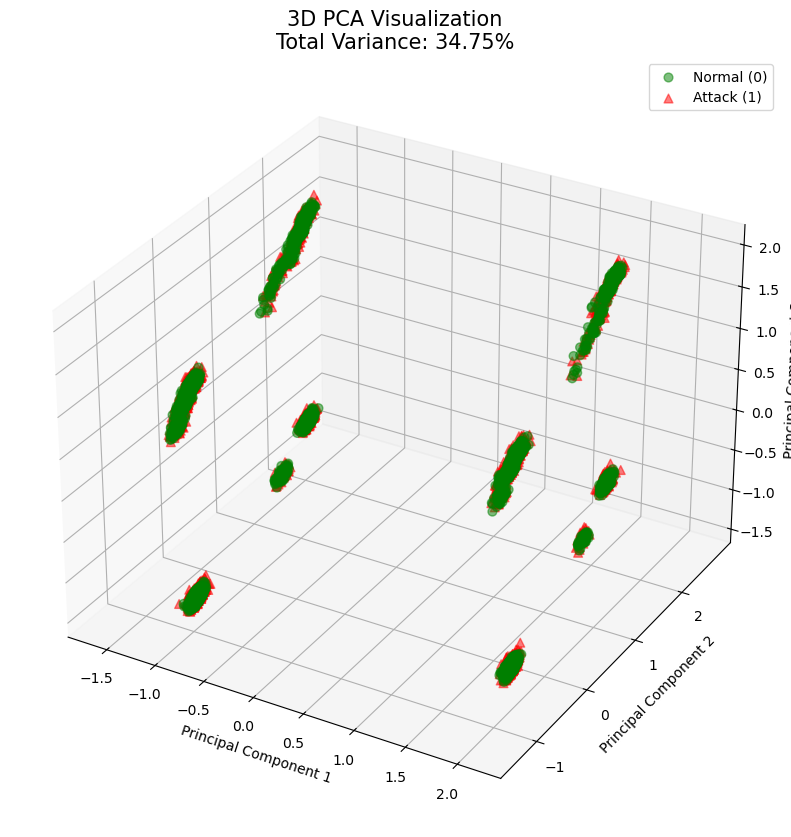

In [699]:
# 1. Run PCA with 3 Components
pca_3d = PCA(n_components=3)
components_3d = pca_3d.fit_transform(X_scaled_for_pca)

# 2. Create a DataFrame for easier plotting
pca_3d_df = pd.DataFrame(data=components_3d, columns=['PC1', 'PC2', 'PC3'])
pca_3d_df['Target'] = y.values

# 3. Calculate Variance Explained
var_explained_3d = pca_3d.explained_variance_ratio_.sum() * 100
print(f"Total Variance Explained in 3D: {var_explained_3d:.2f}%")

# 4. Create the 3D Plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Define colors and labels
targets = [0, 1]
colors = ['green', 'red'] # Blue for Normal, Red for Attack
labels = ['Normal (0)', 'Attack (1)']
markers = ['o', '^'] # Circle for Normal, Triangle for Attack

# Loop through targets to plot each class
for target, color, label, marker in zip(targets, colors, labels, markers):
    indicesToKeep = pca_3d_df['Target'] == target
    ax.scatter(
        pca_3d_df.loc[indicesToKeep, 'PC1'],
        pca_3d_df.loc[indicesToKeep, 'PC2'],
        pca_3d_df.loc[indicesToKeep, 'PC3'],
        c=color,
        label=label,
        marker=marker,
        s=40,      # Size of dots
        alpha=0.5  # Transparency (helps visualize density)
    )

# 5. Formatting
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title(f'3D PCA Visualization\nTotal Variance: {var_explained_3d:.2f}%', fontsize=15)
ax.legend(loc='upper right')
ax.grid(True)

plt.show()

We can see that the variance in general is very low but we have cluster and it proves that it's not random noise.
From the look of the graph we can say that the attack patterns are complex and non-linear and need advanced machine learning models.

In [ ]:
start_time = time.time()

# 1. Initialize UMAP with "Separation" Parameters
# n_neighbors=50: Higher values help preserve the global separation between classes
# min_dist=0.5: Spreads points out more, making the clusters distinct rather than packed tight
reducer = umap.UMAP(n_neighbors=50, min_dist=0.5, n_components=2, random_state=42)

# 2. Fit and Transform
# We pass 'y=y' to make it SUPERVISED. 
# This teaches UMAP to separate Red (1) from Blue (0).
X_umap = reducer.fit_transform(X_scaled_for_pca, y=y) 

# 3. Create DataFrame for Plotting
umap_df = pd.DataFrame(data=X_umap, columns=['UMAP1', 'UMAP2'])
umap_df['Target'] = y.values 

print(f"UMAP finished in {time.time() - start_time:.2f} seconds.")

# 4. Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='UMAP1', 
    y='UMAP2',
    hue='Target', 
    data=umap_df,
    palette={0: 'tab:blue', 1: 'tab:red'},
    alpha=0.6,
    s=60,
    edgecolor='w',
    linewidth=0.5
)

plt.title('Supervised UMAP Projection', fontsize=15)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Attack Detected', loc='upper right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

The UMAP projection shows that the model can distinguish between "attack" and "no attack" scenarios reasonably well, as evidenced by the clustering of red and blue points. Some overlap or mixing of colors may indicate areas where the model struggles to distinguish between classes, or where the data itself is ambiguous.

### Splitting into train and test datasets

In [702]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42) 
# We begin with test_size=0.20 and can fine-tuning it later for better results

### MinMaxScaler
We need to normalize or standardize our features, as session duration is easily has 3 to 4 digit when failed_logins shows no more than one. We need espicially normalized values to use LogisticRegression
As shown by the visualisation step, most of the numerical features doesn't follow a gaussian distribution, beside reputation_score and network_packets_time. We will normalize the data, because StandardScaler assumes that our data follows a gaussian distribution.

We make sure that it only affect numerical values, binary features need to stay as they are.

In [704]:
scaler = MinMaxScaler()
scaler.fit(X_train[numerical_columns])
X_train[numerical_columns], X_test[numerical_columns] = scaler.transform(X_train[numerical_columns]), scaler.transform(X_test[numerical_columns])

In [705]:
X_train # We have normalized our numerical features

,network_packet_size,login_attempts,session_duration,ip_reputation_score,failed_logins,unusual_time_access,AES,DES,Chrome,Edge,Firefox,Safari,Unknown,ICMP,TCP,UDP
417,0.375921,0.000000,0.115964,0.260213,0.2,0.0,False,True,True,False,False,False,False,False,True,False
6782,0.366093,0.083333,0.447440,0.362926,0.0,0.0,False,True,True,False,False,False,False,False,True,False
8042,0.120393,0.250000,0.109494,0.230943,0.2,0.0,True,False,False,False,False,False,True,False,True,False
6499,0.298116,0.166667,0.008855,0.872015,0.4,0.0,False,True,True,False,False,False,False,False,True,False
3506,0.409500,0.083333,0.019021,0.072342,0.4,0.0,False,True,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6558,0.469287,0.166667,0.152435,0.351883,0.4,0.0,True,False,True,False,False,False,False,False,True,False
6602,0.506143,0.416667,0.512547,0.342231,0.4,0.0,True,False,True,False,False,False,False,False,False,True
6808,0.294840,0.166667,0.006736,0.257168,0.8,1.0,True,False,True,False,False,False,False,False,True,False
1075,0.276003,0.333333,0.266441,0.509010,0.4,0.0,True,False,True,False,False,False,False,False,True,False


In [706]:
### Re-sampling
# As said higher in the notebook, we are going to use SMOTE to sample more of the minority class.

Class distribution:
 attack_detected
1    3376
0    3376
Name: count, dtype: int64
Imbalance ratio ≈ 1:1.00


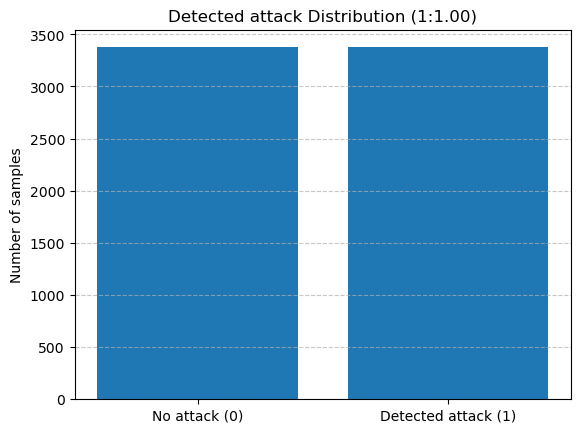

In [707]:
sm = SMOTE(random_state=42)

X_res, y_res = sm.fit_resample(X_train, y_train)
X_train, y_train = X_res, y_res

# And we check the class distribution again
class_counts = y_train.value_counts()
print("Class distribution:\n", class_counts)
minority = class_counts.min()
majority = class_counts.max()
ratio = majority/minority
print(f"Imbalance ratio ≈ 1:{ratio:.2f}")

plt.bar(['No attack (0)', 'Detected attack (1)'], class_counts)
plt.title(f"Detected attack Distribution (1:{ratio:.2f})")
plt.ylabel("Number of samples")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Formulation of the problem

Having analyzed our data and pre-processed it, we have come to the conclusion that our different session IDs suffer countless attacks, an occurrence that we wish to minimize as soon as possible. To study this situation further and find a solution, we have formulated the following problem:

### By using this data, can we predict attacks that are currently happening on our sessions?

In order to predict, we will base our studies on the following variables:

for our 'X' variables: session_id, network_packet_size, protocol_type, login_attempts, session_duration, encryption_used, ip_reputation_score, failed_logins, browser_type, unusual_time_access

for our predict (or 'Y') variable: attack_detected 

# Implementation of a model
To choose, we need to experiment with several algorithms and create multiple pipelines, we will begin with the LogisticRegression

Accuracy: 0.7221122112211221
AUC-ROC Score of Logistic Regression is : 0.7227451070330997
Confusion Matrix:
 [[603 238]
 [183 491]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.72      0.74       841
           1       0.67      0.73      0.70       674

    accuracy                           0.72      1515
   macro avg       0.72      0.72      0.72      1515
weighted avg       0.73      0.72      0.72      1515



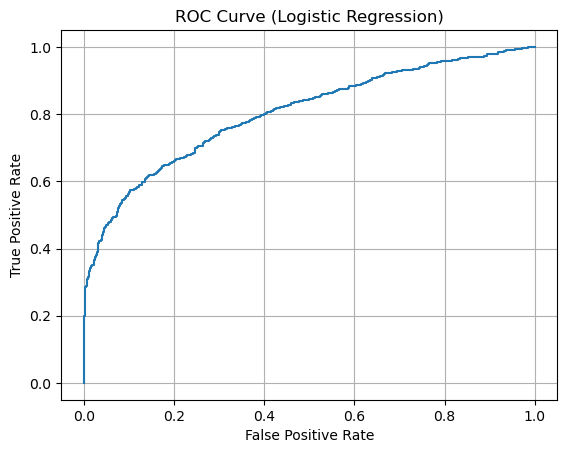

In [711]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]


### Metrics
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
 
print("Accuracy:", accuracy)
print("AUC-ROC Score of Logistic Regression is :", roc_auc_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.title("ROC Curve (Logistic Regression)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.show()

In [712]:
# We have 0.73 in all metrics, which seems to show that we don't have overfitting but can do better.

# Models : Logistic Regression, TreeClassifier, SVM

### Defintion of useful functions to create pipelines, show metrics and results from our differents models

In [715]:
# Metrics list
name_list = []
accuracy_list = []
auc_roc_list = []
f1_score_list = []

In [716]:
# Function for pipeline

def make_pipeline(preprocessing, resampling, model):
    pipe = ImbPipeline([
                ('scaler', preprocessing),
                ('sampling', resampling),
                ('model', model)
    ])
    return pipe

In [717]:
# Shows accuracy, confusion matrix, overall classification report (f1, recall, precision)
def show_metrics(y_test, y_pred, y_proba):

    accuracy = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test,y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
     
    print("Accuracy:", accuracy)
    print("roc-auc score:", roc_auc)
    print("Confusion Matrix:\n", confusion)
    print("Classification Report:\n", classification_rep)

In [718]:
# Function to get the results of the gridSearch, includes displaying best parameters, CV score and return predicted values and probabilities associated
def grid_results(gridSearch):
    print(f"Best parameters found: {gridSearch.best_params_}")
    print(f"Best cross-validation ROC AUC score: {gridSearch.best_score_:.4f}")
    best_model = gridSearch.best_estimator_
    y_pred_grid = best_model.predict(X_test)
    y_proba_grid = best_model.predict_proba(X_test)[:, 1]
    return y_pred_grid, y_proba_grid

# Function to display the roc auc curve
def display_roc_curve(y_test, y_proba_grid):
    print("\nDisplaying ROC Curve")
    plt.figure(figsize=(8, 6))
    
    fpr_grid, tpr_grid, _ = roc_curve(y_test, y_proba_grid)
    plt.plot(fpr_grid, tpr_grid, label=f'Optimal Model (AUC = {roc_auc_score(y_test, y_proba_grid):.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='No Skill (AUC = 0.5)')
    
    plt.title("ROC Curve - Optimal Model")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

In [719]:
numerical_columns = [
    'network_packet_size', 
    'login_attempts', 
    'session_duration', 
    'ip_reputation_score', 
    'failed_logins'
]

categorical_columns = [col for col in X.columns if col not in numerical_columns]

In [720]:
### Prerprocessing for the data in pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_columns),
        ('cat', 'passthrough', categorical_columns) # 'passthrough' leaves the one-hot columns alone
    ],
    remainder='passthrough'
)

In [721]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### LogisticRegression

In [723]:
pipeLR = make_pipeline(preprocessor, SMOTE(random_state=42), LogisticRegression(max_iter=1000, random_state=42))
pipeLR

Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['network_packet_size',
                                                   'login_attempts',
                                                   'session_duration',
                                                   'ip_reputation_score',
                                                   'failed_logins']),
                                                 ('cat', 'passthrough',
                                                  ['unusual_time_access', 'AES',
                                                   'DES', 'Chrome', 'Edge',
                                                   'Firefox', 'Safari',
                                                   'Unknown', 'ICMP', 'TCP',
                                                   'UDP'])])),
                ('sampling', SMOTE(random_state=42)),
                ('model', LogisticRegression(max_iter=1000, random_state=42))])


Logistic Regression
Accuracy: 0.7221122112211221
roc-auc score: 0.8024571567690011
Confusion Matrix:
 [[603 238]
 [183 491]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.72      0.74       841
           1       0.67      0.73      0.70       674

    accuracy                           0.72      1515
   macro avg       0.72      0.72      0.72      1515
weighted avg       0.73      0.72      0.72      1515


Displaying ROC Curve


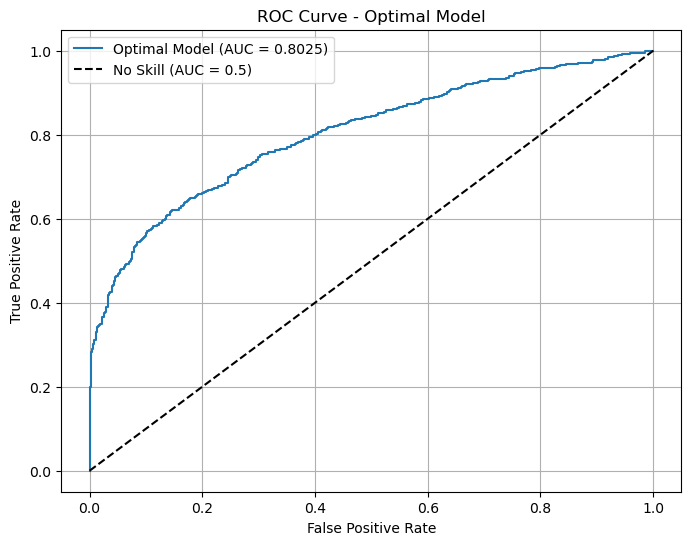

In [724]:
# Results
pipeLR.fit(X_train, y_train)
y_pred, y_proba = pipeLR.predict(X_test), pipeLR.predict_proba(X_test)[:,-1]

print("\nLogistic Regression")
show_metrics(y_test, y_pred, y_proba)
display_roc_curve(y_test, y_proba)

In [725]:
name_list.append("ROC AUC score")
accuracy_list.append(accuracy_score(y_test, y_pred))
f1_score_list.append(f1_score(y_test, y_pred))
auc_roc_list.append(roc_auc_score(y_test, y_proba))

### Tree Algorithm

In [727]:
### TreeClassifier

pipeline_tree = make_pipeline(preprocessor, SMOTE(random_state=42), DecisionTreeClassifier(random_state=42))
pipeline_tree

Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['network_packet_size',
                                                   'login_attempts',
                                                   'session_duration',
                                                   'ip_reputation_score',
                                                   'failed_logins']),
                                                 ('cat', 'passthrough',
                                                  ['unusual_time_access', 'AES',
                                                   'DES', 'Chrome', 'Edge',
                                                   'Firefox', 'Safari',
                                                   'Unknown', 'ICMP', 'TCP',
                                                   'UDP'])])),
                ('sampling', SMOTE(random_state=42)),
                ('model', DecisionTreeClassifier(random_state=42))])


DecisionTreeClassifier
Accuracy: 0.8250825082508251
roc-auc score: 0.8260981169090069
Confusion Matrix:
 [[687 154]
 [111 563]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.82      0.84       841
           1       0.79      0.84      0.81       674

    accuracy                           0.83      1515
   macro avg       0.82      0.83      0.82      1515
weighted avg       0.83      0.83      0.83      1515


Displaying ROC Curve


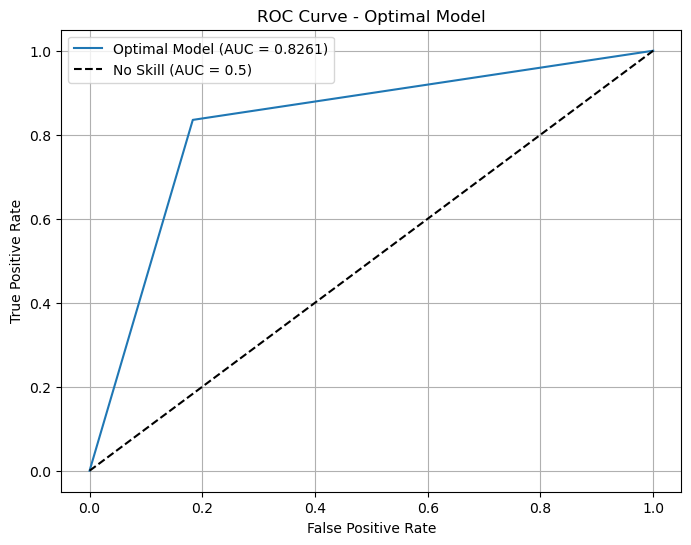

In [728]:
# Results
pipeline_tree.fit(X_train, y_train)
y_pred, y_proba = pipeline_tree.predict(X_test), pipeline_tree.predict_proba(X_test)[:,-1]

print("\nDecisionTreeClassifier")
show_metrics(y_test, y_pred, y_proba)
display_roc_curve(y_test, y_proba)

In [729]:
name_list.append("DecisionTreeClassifier")
accuracy_list.append(accuracy_score(y_test, y_pred))
f1_score_list.append(f1_score(y_test, y_pred))
auc_roc_list.append(roc_auc_score(y_test, y_proba))

### SVM Algorithm

In [731]:
### SVM
pipeline_svm = make_pipeline(preprocessor, SMOTE(random_state=42), SVC(random_state=42, probability=True))

SVM
Accuracy: 0.8165016501650165
roc-auc score: 0.8260981169090069
Confusion Matrix:
 [[728 113]
 [165 509]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.87      0.84       841
           1       0.82      0.76      0.79       674

    accuracy                           0.82      1515
   macro avg       0.82      0.81      0.81      1515
weighted avg       0.82      0.82      0.82      1515


Displaying ROC Curve


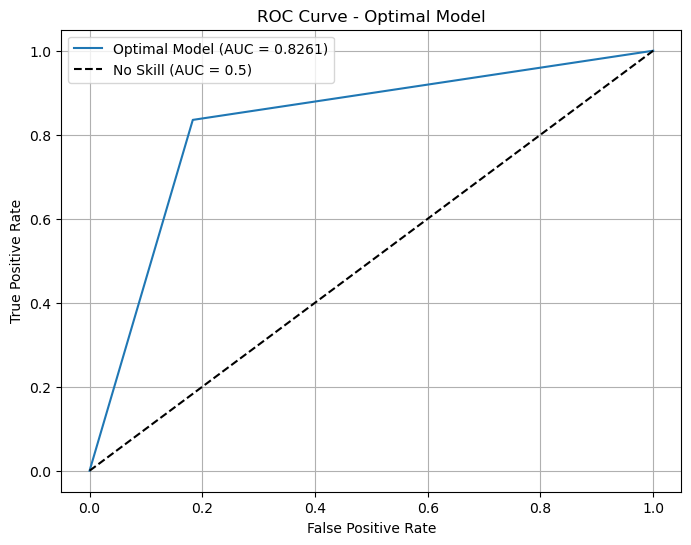

In [732]:
# Results
pipeline_svm.fit(X_train, y_train)
y_pred, y_proba = pipeline_svm.predict(X_test), pipeline_tree.predict_proba(X_test)[:,-1]

print("SVM")
show_metrics(y_test, y_pred, y_proba)
display_roc_curve(y_test, y_proba)

In [733]:
name_list.append("SVM")
accuracy_list.append(accuracy_score(y_test, y_pred))
f1_score_list.append(f1_score(y_test, y_pred))
auc_roc_list.append(roc_auc_score(y_test, y_proba))

# Apply Grid Search
To establish the optimal configuration of our baseline models

### Logistic Regression Grid

In [736]:
param_grid_LR = [
    # Grid for liblinear
    {
        'model__solver': ['liblinear'],
        'model__penalty': ['l1', 'l2'],
        'model__C': np.logspace(-4, 4, 10)
    },
    
    # Grid for lbfgs
    {
        'model__solver': ['lbfgs'],
        'model__penalty': ['l2'],
        'model__C': np.logspace(-4, 4, 10)
    },
    
    # Grid for saga with elasticnet
    {
        'model__solver': ['saga'],
        'model__max_iter': [1000], 
        'model__penalty': ['elasticnet'],
        'model__C': np.logspace(-4, 4, 10),
        'model__l1_ratio': [0, 0.25, 0.5, 0.75, 1] # Only for elasticnet
    },
    
    # Grid for saga with l1 and l2
    {
        'model__solver': ['saga'],
        'model__max_iter': [1000],
        'model__penalty': ['l1', 'l2'],
        'model__C': np.logspace(-4, 4, 10) # No l1_ratio here
    }
]

grid_searchLR = GridSearchCV(
    estimator=pipeLR,  # Use the pipeline as the estimator
    param_grid=param_grid_LR,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_searchLR.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['network_packet_size',
                                                                          'login_attempts',
                                                                          'session_duration',
                                                                          'ip_reputation_score',
                                                                          'failed_logins']),
                                                                        ('cat',
                                                                         'passthrough',
                                                                         ['unusual_time_access',
                                                                          'AES',
                                                                          'DES',
                                                                          'Chrome',
                                                                          'Edge',
                                                                          'Firefox',
                                                                          'Safari',
                                                                          'Unknown',
                                                                          'ICMP',
                                                                          'TCP',
                                                                          'UDP'...
                          'model__max_iter': [1000],
                          'model__penalty': ['elasticnet'],
                          'model__solver': ['saga']},
                         {'model__C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                          'model__max_iter': [1000],
                          'model__penalty': ['l1', 'l2'],
                          'model__solver': ['saga']}],
             scoring='roc_auc', verbose=2)

Best parameters found: {'model__C': 0.3593813663804626, 'model__l1_ratio': 1, 'model__max_iter': 1000, 'model__penalty': 'elasticnet', 'model__solver': 'saga'}
Best cross-validation ROC AUC score: 0.8083

Optimal Model Metrics (from Grid Search)
Accuracy: 0.7234323432343235
roc-auc score: 0.802531252536016
Confusion Matrix:
 [[604 237]
 [182 492]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.72      0.74       841
           1       0.67      0.73      0.70       674

    accuracy                           0.72      1515
   macro avg       0.72      0.72      0.72      1515
weighted avg       0.73      0.72      0.72      1515


Displaying ROC Curve


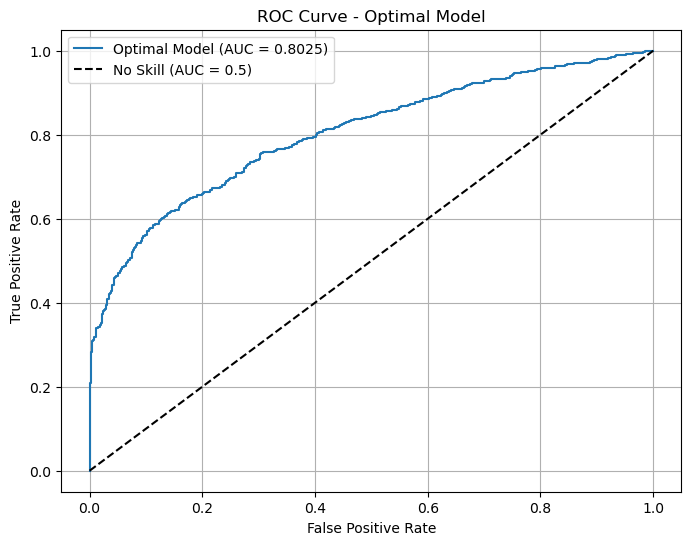

In [737]:
# Results from the GridSearch
y_pred_grid, y_proba_grid = grid_results(grid_searchLR)

print("\nOptimal Model Metrics (from Grid Search)")
show_metrics(y_test, y_pred_grid, y_proba_grid)

display_roc_curve(y_test, y_proba_grid)

In [738]:
name_list.append("Logistic Regression Grid")
accuracy_list.append(accuracy_score(y_test, y_pred_grid))
f1_score_list.append(f1_score(y_test, y_pred_grid))
auc_roc_list.append(roc_auc_score(y_test, y_proba_grid))

### Tree Grid

In [740]:
# Parameters for GridSearch Tree
param_grid_tree = {
    'model__criterion': ['gini', 'entropy'], 
    'model__max_depth' : [3, 5, 10, None],
    'model__min_samples_split' : [2, 5, 10]
    # 'n_estimators' : [1, 2, 5, 10, 15],
    # 'max_samples' : [5, 10, 25, 50]
}

# Grid
grid_searchTree = GridSearchCV(pipeline_tree, param_grid_tree, scoring='roc_auc', refit=True, cv=5, n_jobs=-1, verbose=2)
grid_searchTree.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['network_packet_size',
                                                                          'login_attempts',
                                                                          'session_duration',
                                                                          'ip_reputation_score',
                                                                          'failed_logins']),
                                                                        ('cat',
                                                                         'passthrough',
                                                                         ['unusual_time_access',
                                                                          'AES',
                                                                          'DES',
                                                                          'Chrome',
                                                                          'Edge',
                                                                          'Firefox',
                                                                          'Safari',
                                                                          'Unknown',
                                                                          'ICMP',
                                                                          'TCP',
                                                                          'UDP'])])),
                                       ('sampling', SMOTE(random_state=42)),
                                       ('model',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [3, 5, 10, None],
                         'model__min_samples_split': [2, 5, 10]},
             scoring='roc_auc', verbose=2)

Best parameters found: {'model__criterion': 'entropy', 'model__max_depth': 5, 'model__min_samples_split': 2}
Best cross-validation ROC AUC score: 0.8822

Optimal Model Metrics (from Grid Search)
Accuracy: 0.8996699669966997
roc-auc score: 0.8874044252814757
Confusion Matrix:
 [[841   0]
 [152 522]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92       841
           1       1.00      0.77      0.87       674

    accuracy                           0.90      1515
   macro avg       0.92      0.89      0.90      1515
weighted avg       0.92      0.90      0.90      1515


Displaying ROC Curve


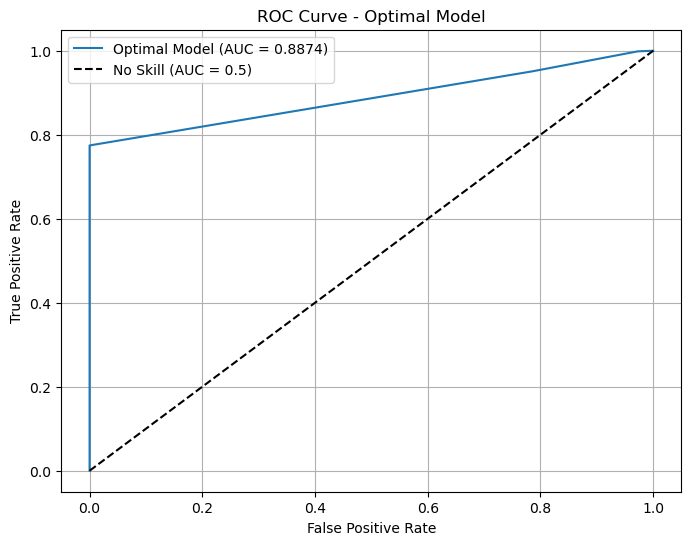

In [741]:
# Results from the GridSearch
y_pred_grid, y_proba_grid = grid_results(grid_searchTree)

print("\nOptimal Model Metrics (from Grid Search)")
show_metrics(y_test, y_pred_grid, y_proba_grid)

display_roc_curve(y_test, y_proba_grid)

[Text(0.7777777777777778, 0.9166666666666666, 'x[4] <= 2.5\ngini = 0.493\nsamples = 6056\nvalue = [3376.0, 2680.0]'),
 Text(0.6666666666666666, 0.75, 'x[1] <= 6.5\ngini = 0.444\nsamples = 5061\nvalue = [3376, 1685]'),
 Text(0.5555555555555556, 0.5833333333333334, 'x[3] <= 0.6\ngini = 0.38\nsamples = 4532\nvalue = [3376, 1156]'),
 Text(0.4444444444444444, 0.4166666666666667, 'x[12] <= 0.5\ngini = 0.301\nsamples = 4141\nvalue = [3376, 765]'),
 Text(0.2222222222222222, 0.25, 'x[2] <= 2550.521\ngini = 0.269\nsamples = 3923\nvalue = [3294, 629]'),
 Text(0.1111111111111111, 0.08333333333333333, 'gini = 0.264\nsamples = 3798\nvalue = [3204, 594]'),
 Text(0.3333333333333333, 0.08333333333333333, 'gini = 0.403\nsamples = 125\nvalue = [90, 35]'),
 Text(0.6666666666666666, 0.25, 'x[1] <= 3.5\ngini = 0.469\nsamples = 218\nvalue = [82, 136]'),
 Text(0.5555555555555556, 0.08333333333333333, 'gini = 0.209\nsamples = 93\nvalue = [82, 11]'),
 Text(0.7777777777777778, 0.08333333333333333, 'gini = 0.0\ns

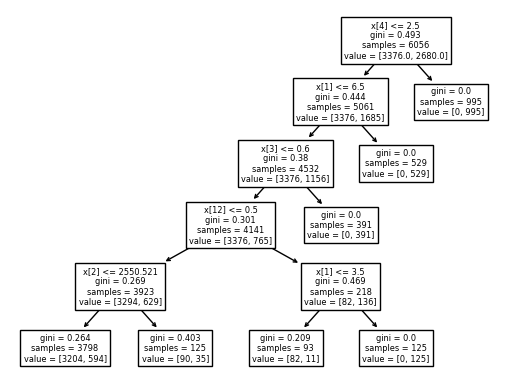

In [742]:
# Based on the best params of the pipeline
grid_searchTree.best_params_
clf = DecisionTreeClassifier(max_depth=5, min_samples_split=2, random_state=42)
clf.fit(X_train, y_train)
tree.plot_tree(clf)

In [743]:
name_list.append("DecisionTreeClassifier Grid")
accuracy_list.append(accuracy_score(y_test, y_pred_grid))
f1_score_list.append(f1_score(y_test, y_pred_grid))
auc_roc_list.append(roc_auc_score(y_test, y_proba_grid))

### SVM Grid

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found: {'model__C': 100, 'model__gamma': 0.1}
Best cross-validation ROC AUC score: 0.8774

Optimal Model Metrics (from Grid Search)
Accuracy: 0.8514851485148515
roc-auc score: 0.8802974062953175
Confusion Matrix:
 [[769  72]
 [153 521]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87       841
           1       0.88      0.77      0.82       674

    accuracy                           0.85      1515
   macro avg       0.86      0.84      0.85      1515
weighted avg       0.85      0.85      0.85      1515


Displaying ROC Curve


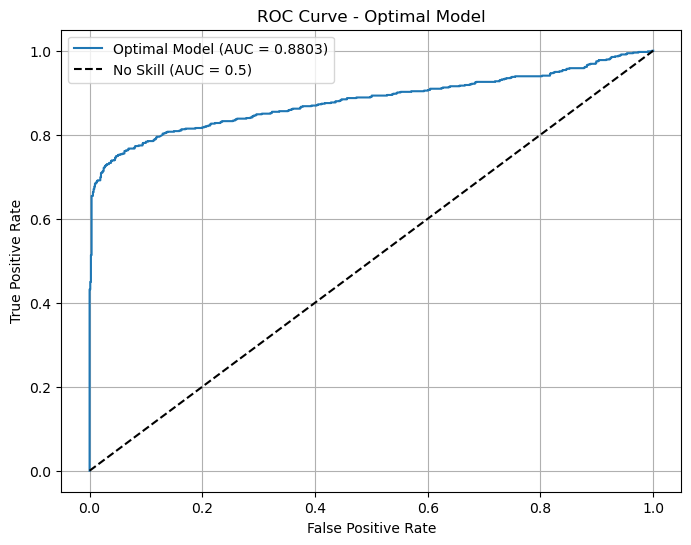

In [745]:
# Parameters for GridSearch SVM
param_grid_svm = {
    'model__C' : [0.1, 1, 10, 100],
    'model__gamma' : [1, 0.1, 0.01, 0.001]
}


# Grid
grid_searchSVM = GridSearchCV(
    estimator=pipeline_svm,  # Use the pipeline as the estimator
    param_grid=param_grid_svm,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_searchSVM.fit(X_train, y_train)

# Results from the GridSearch
y_pred_grid, y_proba_grid = grid_results(grid_searchSVM)

print("\nOptimal Model Metrics (from Grid Search)")
show_metrics(y_test, y_pred_grid, y_proba_grid)

display_roc_curve(y_test, y_proba_grid)

In [746]:
name_list.append("SVM Grid")
accuracy_list.append(accuracy_score(y_test, y_pred_grid))
f1_score_list.append(f1_score(y_test, y_pred_grid))
auc_roc_list.append(roc_auc_score(y_test, y_proba_grid))

# Bagging models

### Logistic Regression

In [749]:
pipeBag_LR = make_pipeline(preprocessor, SMOTE(random_state=42), BaggingClassifier(estimator=LogisticRegression(random_state=42), random_state=42))
pipeBag_LR

Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['network_packet_size',
                                                   'login_attempts',
                                                   'session_duration',
                                                   'ip_reputation_score',
                                                   'failed_logins']),
                                                 ('cat', 'passthrough',
                                                  ['unusual_time_access', 'AES',
                                                   'DES', 'Chrome', 'Edge',
                                                   'Firefox', 'Safari',
                                                   'Unknown', 'ICMP', 'TCP',
                                                   'UDP'])])),
                ('sampling', SMOTE(random_state=42)),
                ('model',
                 BaggingClassifier(estimator=LogisticRegression(random_state=42),
                                   random_state=42))])

In [750]:
param_grid_LR = [
    
    # Grid for saga with elasticnet
    {
        'model__estimator__solver': ['saga'],
        'model__estimator__max_iter': [1000], 
        'model__estimator__penalty': ['elasticnet'],
        'model__estimator__C': np.logspace(0, 2, 10),
        'model__estimator__l1_ratio': [0.75, 1], # Only for elasticnet
        'model__n_estimators' : [5, 10, 15],
        'model__max_samples' : [5, 25, 50]
    }]

bagGrid_searchLR = GridSearchCV(
    estimator=pipeBag_LR,  # Use the pipeline as the estimator
    param_grid=param_grid_LR,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# bagGrid_searchLR.fit(X_train, y_train) # takes to long to execute

In [751]:
"""
# Results from the GridSearch
y_pred_grid, y_proba_grid = grid_results(bagGrid_searchLR)

print("\nOptimal Model Metrics (from Grid Search with bagging)")
show_metrics(y_test, y_pred_grid, y_proba_grid)

display_roc_curve(y_test, y_proba_grid)

name_list.append("Logistic Regression Grid Bagging")
accuracy_list.append(accuracy_score(y_test, y_pred_grid))
f1_score_list.append(f1_score(y_test, y_pred_grid))
auc_roc_list.append(roc_auc_score(y_test, y_proba_grid))
"""

'\n# Results from the GridSearch\ny_pred_grid, y_proba_grid = grid_results(bagGrid_searchLR)\n\nprint("\nOptimal Model Metrics (from Grid Search with bagging)")\nshow_metrics(y_test, y_pred_grid, y_proba_grid)\n\ndisplay_roc_curve(y_test, y_proba_grid)\n\nname_list.append("Logistic Regression Grid Bagging")\naccuracy_list.append(accuracy_score(y_test, y_pred_grid))\nf1_score_list.append(f1_score(y_test, y_pred_grid))\nauc_roc_list.append(roc_auc_score(y_test, y_proba_grid))\n'

### TreeClassifier
TreeClassifier with Grid and Bagging

In [753]:
# Pipeline
pipeBag_tree = make_pipeline(preprocessor, SMOTE(random_state=42), BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), random_state=42))
pipeBag_tree

Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['network_packet_size',
                                                   'login_attempts',
                                                   'session_duration',
                                                   'ip_reputation_score',
                                                   'failed_logins']),
                                                 ('cat', 'passthrough',
                                                  ['unusual_time_access', 'AES',
                                                   'DES', 'Chrome', 'Edge',
                                                   'Firefox', 'Safari',
                                                   'Unknown', 'ICMP', 'TCP',
                                                   'UDP'])])),
                ('sampling', SMOTE(random_state=42)),
                ('model',
                 BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42),
                                   random_state=42))])

In [754]:
# Parameters for GridSearch Tree
param_grid_tree = {
    'model__estimator__criterion': ['gini', 'entropy'], 
    'model__estimator__max_depth' : [3, 5, 10, None],
    'model__estimator__min_samples_split' : [2, 5, 10],
    'model__n_estimators' : [1, 2, 5, 10, 15],
    'model__max_samples' : [5, 10, 25, 50]
}

# Grid
bagGrid_searchTree = GridSearchCV(pipeBag_tree, param_grid_tree, scoring='roc_auc', refit=True, cv=5, n_jobs=-1, verbose=2)
bagGrid_searchTree.fit(X_train, y_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['network_packet_size',
                                                                          'login_attempts',
                                                                          'session_duration',
                                                                          'ip_reputation_score',
                                                                          'failed_logins']),
                                                                        ('cat',
                                                                         'passthrough',
                                                                         ['unusual_time_access',
                                                                          'AES',
                                                                          'DES',
                                                                          'Chrome',
                                                                          'Edge',
                                                                          'Firefox',
                                                                          'Safari',
                                                                          'Unknown',
                                                                          'ICMP',
                                                                          'TCP',
                                                                          'UDP'...
                                       ('model',
                                        BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42),
                                                          random_state=42))]),
             n_jobs=-1,
             param_grid={'model__estimator__criterion': ['gini', 'entropy'],
                         'model__estimator__max_depth': [3, 5, 10, None],
                         'model__estimator__min_samples_split': [2, 5, 10],
                         'model__max_samples': [5, 10, 25, 50],
                         'model__n_estimators': [1, 2, 5, 10, 15]},
             scoring='roc_auc', verbose=2)

Best parameters found: {'model__estimator__criterion': 'gini', 'model__estimator__max_depth': 5, 'model__estimator__min_samples_split': 2, 'model__max_samples': 50, 'model__n_estimators': 15}
Best cross-validation ROC AUC score: 0.8767

Optimal Model Metrics (from Grid Search with bagging)
Accuracy: 0.8732673267326733
roc-auc score: 0.8882512340473578
Confusion Matrix:
 [[809  32]
 [160 514]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.96      0.89       841
           1       0.94      0.76      0.84       674

    accuracy                           0.87      1515
   macro avg       0.89      0.86      0.87      1515
weighted avg       0.88      0.87      0.87      1515


Displaying ROC Curve


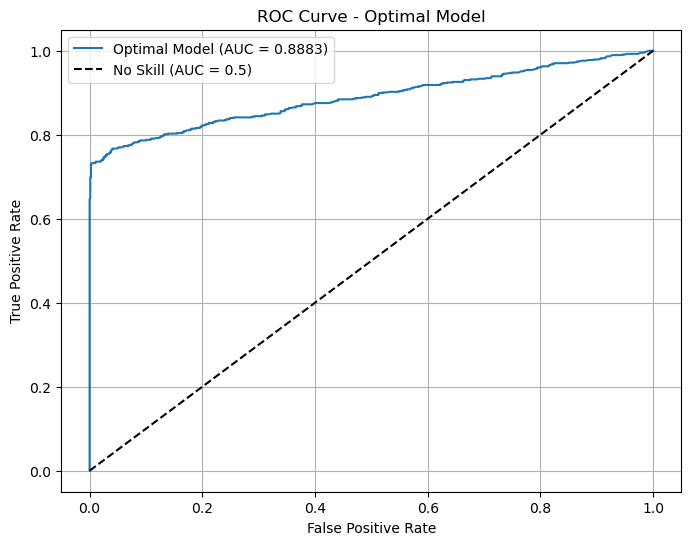

In [755]:
# Results from the GridSearch
y_pred_grid, y_proba_grid = grid_results(bagGrid_searchTree)

print("\nOptimal Model Metrics (from Grid Search with bagging)")
show_metrics(y_test, y_pred_grid, y_proba_grid)

display_roc_curve(y_test, y_proba_grid)

In [756]:
name_list.append("Tree Grid Bagging")
accuracy_list.append(accuracy_score(y_test, y_pred_grid))
f1_score_list.append(f1_score(y_test, y_pred_grid))
auc_roc_list.append(roc_auc_score(y_test, y_proba_grid))

### SVM

In [758]:
pipeBag_svm = make_pipeline(preprocessor, SMOTE(random_state=42), BaggingClassifier(estimator=SVC(random_state=42, probability=True), random_state=42))
pipeBag_svm

Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['network_packet_size',
                                                   'login_attempts',
                                                   'session_duration',
                                                   'ip_reputation_score',
                                                   'failed_logins']),
                                                 ('cat', 'passthrough',
                                                  ['unusual_time_access', 'AES',
                                                   'DES', 'Chrome', 'Edge',
                                                   'Firefox', 'Safari',
                                                   'Unknown', 'ICMP', 'TCP',
                                                   'UDP'])])),
                ('sampling', SMOTE(random_state=42)),
                ('model',
                 BaggingClassifier(estimator=SVC(probability=True,
                                                 random_state=42),
                                   random_state=42))])

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best parameters found: {'model__estimator__C': 100, 'model__estimator__gamma': 0.1, 'model__max_samples': 50, 'model__n_estimators': 15}
Best cross-validation ROC AUC score: 0.8063

Optimal Model Metrics (from Grid Search with bagging)
Accuracy: 0.7207920792079208
roc-auc score: 0.7934298224877124
Confusion Matrix:
 [[638 203]
 [220 454]]
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.76      0.75       841
           1       0.69      0.67      0.68       674

    accuracy                           0.72      1515
   macro avg       0.72      0.72      0.72      1515
weighted avg       0.72      0.72      0.72      1515


Displaying ROC Curve


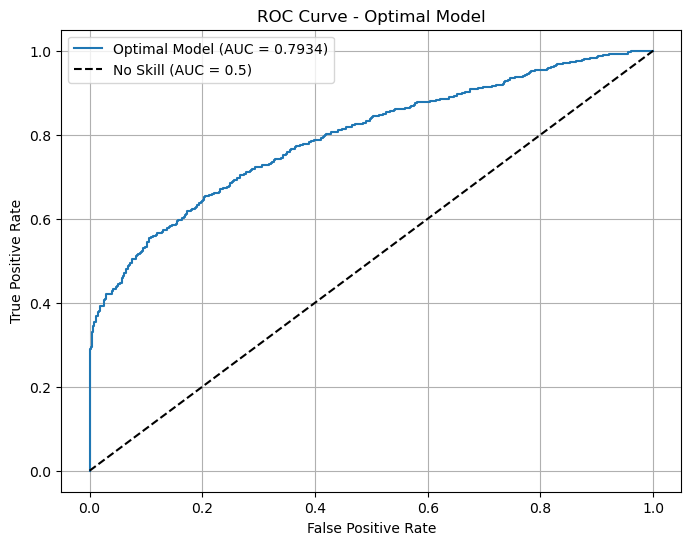

In [759]:
# Parameters for GridSearch SVM
param_grid_svm = {
    'model__estimator__C' : [0.1, 1, 10, 100],
    'model__estimator__gamma' : [1, 0.1, 0.01, 0.001],
    'model__n_estimators' : [1, 2, 5, 10, 15],
    'model__max_samples' : [5, 10, 25, 50]
}


# Grid
bagGrid_searchSVM = GridSearchCV(
    estimator=pipeBag_svm,  # Use the pipeline as the estimator
    param_grid=param_grid_svm,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=2
)

bagGrid_searchSVM.fit(X_train, y_train)

# Results from the GridSearch
y_pred_grid, y_proba_grid = grid_results(bagGrid_searchSVM)

print("\nOptimal Model Metrics (from Grid Search with bagging)")
show_metrics(y_test, y_pred_grid, y_proba_grid)

display_roc_curve(y_test, y_proba_grid)

In [760]:
name_list.append("SVM Grid Bagging")
accuracy_list.append(accuracy_score(y_test, y_pred_grid))
f1_score_list.append(f1_score(y_test, y_pred_grid))
auc_roc_list.append(roc_auc_score(y_test, y_proba_grid))

## Voting Classifier

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Accuracy: 0.8270627062706271
roc-auc score: 0.8227258774173744
Confusion Matrix:
 [[725 116]
 [146 528]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.86      0.85       841
           1       0.82      0.78      0.80       674

    accuracy                           0.83      1515
   macro avg       0.83      0.82      0.82      1515
weighted avg       0.83      0.83      0.83      1515


Displaying ROC Curve


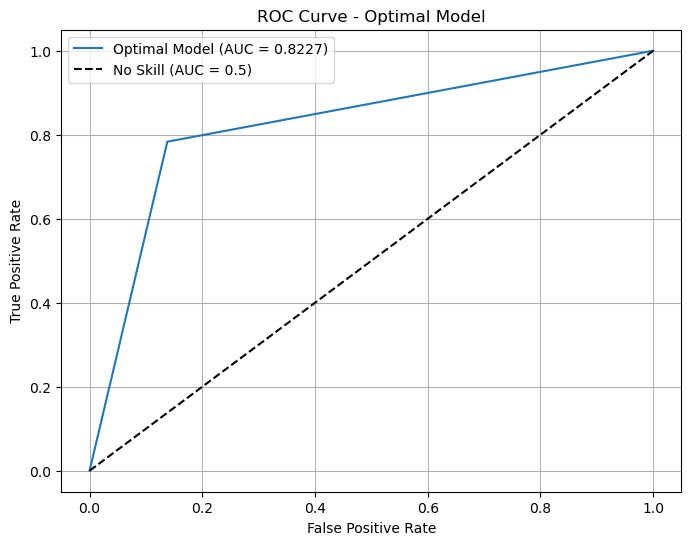

In [763]:
voting_clf_soft = VotingClassifier(
    estimators=[
        #("Bagging LogisticRegression", bagGrid_searchLR),
        ("LogisticRegression", grid_searchLR),
        ("Bagging SVM", bagGrid_searchSVM),  
        ("Bagging Tree", bagGrid_searchTree), 
    ],
    voting='soft' 
)

voting_clf_soft.fit(X_train,y_train)
y_pred_votclf = voting_clf_soft.predict(X_test)
y_proba_votclf = voting_clf_soft.predict(X_test)

show_metrics(y_test, y_pred_votclf, y_proba_votclf)
display_roc_curve(y_test, y_proba_votclf)

name_list.append("Voting Classifier 1")
accuracy_list.append(accuracy_score(y_test, y_pred_votclf))
f1_score_list.append(f1_score(y_test, y_pred_votclf))
auc_roc_list.append(roc_auc_score(y_test, y_proba_votclf))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Accuracy: 0.8693069306930693
roc-auc score: 0.8603338896396476
Confusion Matrix:
 [[792  49]
 [149 525]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89       841
           1       0.91      0.78      0.84       674

    accuracy                           0.87      1515
   macro avg       0.88      0.86      0.87      1515
weighted avg       0.87      0.87      0.87      1515


Displaying ROC Curve


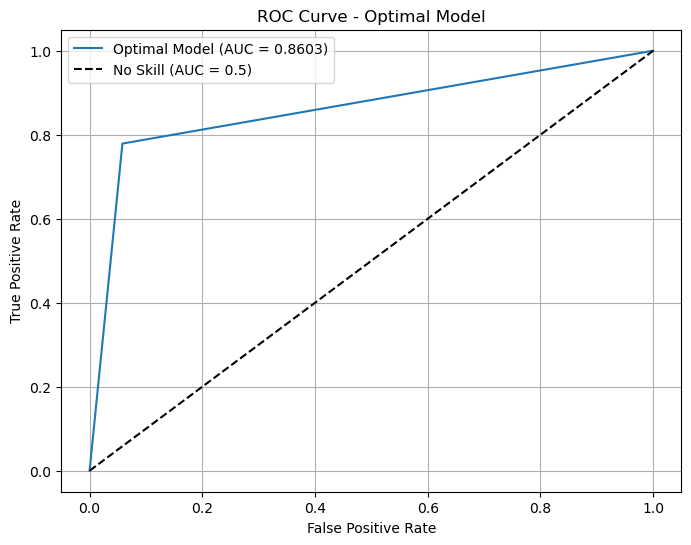

In [764]:
voting_clf_soft = VotingClassifier(
    estimators=[
        ("Grid Tree", grid_searchTree),
        ("Grid SVM", grid_searchSVM),
        ("Grid LogisticRegression", grid_searchLR),
        #("Bagging LogisticRegression", bagGrid_searchLR),
        ("Bagging SVM", bagGrid_searchSVM),  
        ("Bagging Tree", bagGrid_searchTree), 
    ],
    voting='soft' 
)

voting_clf_soft.fit(X_train,y_train)
y_pred_votclf = voting_clf_soft.predict(X_test)
y_proba_votclf = voting_clf_soft.predict(X_test)

show_metrics(y_test, y_pred_votclf, y_proba_votclf)
display_roc_curve(y_test, y_proba_votclf)

name_list.append("Voting Classifier 2")
accuracy_list.append(accuracy_score(y_test, y_pred_votclf))
f1_score_list.append(f1_score(y_test, y_pred_votclf))
auc_roc_list.append(roc_auc_score(y_test, y_proba_votclf))

# Comparaisons of models

In [766]:
## Comparaisons of all grid LogisticRegression, TreeClassifier and SVM
print("Models :", name_list)
print("Accuracy :", accuracy_list)
print("F1 score :", f1_score_list)
print("ROC AUC score :", auc_roc_list)

Models : ['ROC AUC score', 'DecisionTreeClassifier', 'SVM', 'Logistic Regression Grid', 'DecisionTreeClassifier Grid', 'SVM Grid', 'Tree Grid Bagging', 'SVM Grid Bagging', 'Voting Classifier 1', 'Voting Classifier 2']
Accuracy : [0.7221122112211221, 0.8250825082508251, 0.8165016501650165, 0.7234323432343235, 0.8996699669966997, 0.8514851485148515, 0.8732673267326733, 0.7207920792079208, 0.8270627062706271, 0.8693069306930693]
F1 score : [0.699928724162509, 0.809489575844716, 0.7854938271604939, 0.7013542409123307, 0.8729096989966555, 0.8224151539068666, 0.8426229508196721, 0.6821938392186326, 0.8012139605462822, 0.8413461538461539]
ROC AUC score : [0.8024571567690011, 0.8260981169090069, 0.8260981169090069, 0.802531252536016, 0.8874044252814757, 0.8802974062953175, 0.8882512340473578, 0.7934298224877124, 0.8227258774173744, 0.8603338896396476]


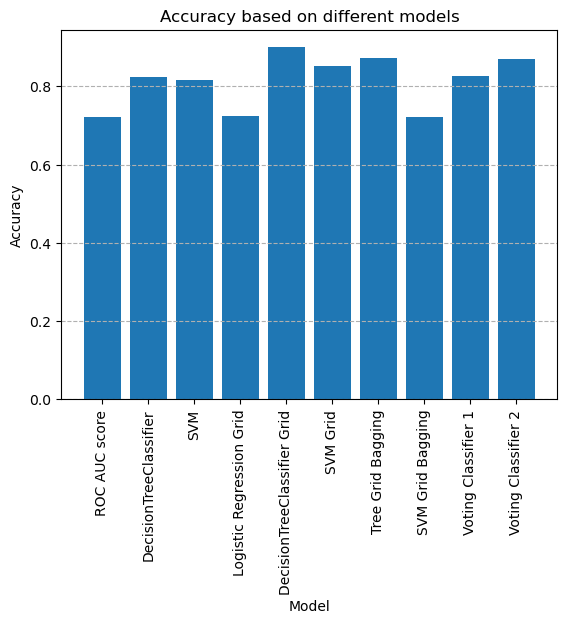

In [767]:
# Accuracies
plt.bar(name_list, accuracy_list)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Accuracy based on different models")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--')
plt.show()

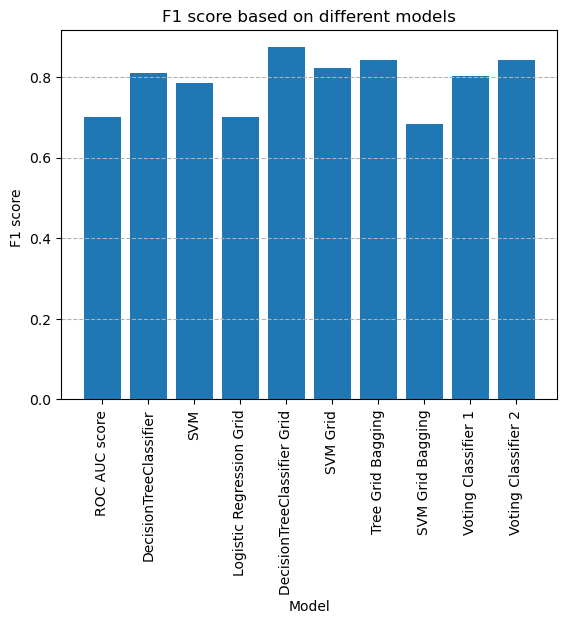

In [768]:
# f1_score_list
plt.bar(name_list, f1_score_list)
plt.xlabel("Model")
plt.ylabel("F1 score ")
plt.title("F1 score based on different models")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--')
plt.show()

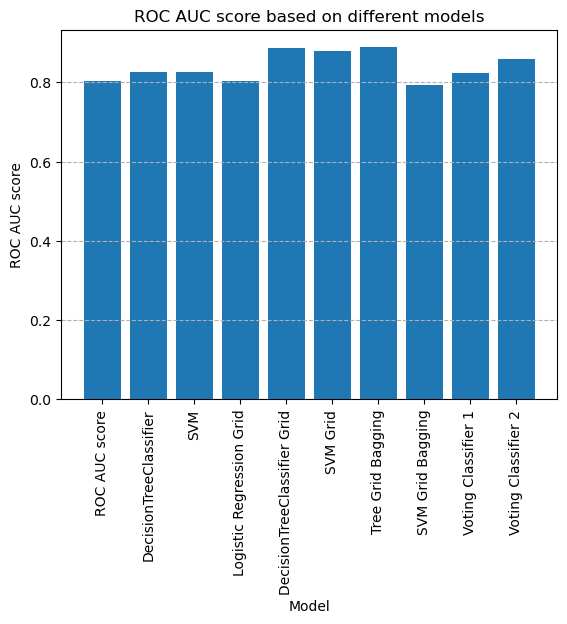

In [769]:
# ROC AUC score
plt.bar(name_list, auc_roc_list)
plt.xlabel("Model")
plt.ylabel("ROC AUC score")
plt.title("ROC AUC score based on different models")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--')
plt.show()